In [6]:
library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(RColorBrewer)
library(tidyr)
library(dplyr)
library(readxl)
library(stringr)
library(DoubletFinder)
library(repr)

In [7]:
set.seed(1)
options(repr.plot.width = 12, repr.plot.height = 10)

In [8]:
load_data <- function(filename) {
    df = read.csv(paste("../data/processed_data/mutations_with_subtypes", 
                        filename, sep="/"))
    return(df)
}

In [9]:
perform_analysis <- function(df, 
                             scale,
                             normalize,
                             dim_reduction_method,
                             plot_title,
                             color_by,
                             seurat_clustering,
                             conduct_test,
                             min_mutations_per_sample,
                             save_clustered_mutations,
                             regress_out_counts,
                             harmonize=FALSE,
                             harmony_batch_var="",
                             seurat_func_args=
                               list(normalize_data_args=list(normalization.method=
                                                               "LogNormalize"),
                                    find_var_features_args=list(nfeatures=2000),
                                    scale_data_args=list(verbose=F),
                                    pca_args=list(npcs=30, approx_svd=F, verbose=F),
                                    umap_args=list(n.neighbors=30, dims=1:15, verbose=F),
                                    tsne_args=list(dims=1:15, seed=42),
                                    find_neighbors_args=list(dims=1:20),
                                    find_clusters_args=list(resolution=0.7)),
                            manually_supplied_cols=c()) {

  print("Performing Seurat analysis...")   
  normalize_data_args=seurat_func_args$normalize_data_args
  find_var_features_args = seurat_func_args$find_var_features_args
  scale_data_args = seurat_func_args$scale_data_args
  pca_args = seurat_func_args$pca_args
  umap_args = seurat_func_args$umap_args
  tsne_args = seurat_func_args$tsne_args
  find_neighbors_args = seurat_func_args$find_neighbors_args
  find_clusters_args = seurat_func_args$find_clusters_args
  
  chr_ranges = colnames(df)[grepl("chr[0-9]", colnames(df))]
  
  mutations_df = df[, grepl("chr[0-9]", colnames(df))]
  mutations_df = t(mutations_df)
  
  colnames(mutations_df) = df[["donor_id"]]
  print("Creating Seurat Object...")
  seurat_data = CreateSeuratObject(counts = mutations_df)
  
  if (!color_by == "mut_counts" && !color_by == "seurat_clusters__categorical") {
    data_color_by = df[[color_by]]
  }
  
  metadata = seurat_data@meta.data
  colnames(metadata)[grepl("nCount_RNA", colnames(metadata))] = "mut_counts"
  seurat_data@meta.data = metadata
  
  print("Adding metadata...")
  if (color_by != "seurat_clusters__categorical" && color_by != "mut_counts") {
    if (grepl("__categorical", color_by)) {
      seurat_data = AddMetaData(object = seurat_data, metadata = 
                                  data_color_by, col.name = color_by)
    } else {
      seurat_data = AddMetaData(object = seurat_data, metadata = 
                                  as.numeric(data_color_by), 
                                col.name = color_by)
    }
  }
  
  seurat_data = seurat_data[, seurat_data@meta.data$mut_counts >= min_mutations_per_sample]
  
  if (normalize) {
    print("Normalizing data...")
    seurat_data = NormalizeData(seurat_data, 
                                normalization.method = 
                                  normalize_data_args$normalization.method)
  }
  
  print("Finding Variable Features...")
  seurat_data = FindVariableFeatures(seurat_data,
                                     nfeatures=find_var_features_args$nfeatures)
  
  if (scale) {
    print("Scaling data...")
    if (regress_out_counts) {
      seurat_data = ScaleData(seurat_data, vars.to.regress = "mut_counts")
    }
    else {
      seurat_data = ScaleData(seurat_data)
    }
  }
  
  print("Running PCA...")
  seurat_data = RunPCA(seurat_data, 
                       npcs=pca_args$npcs, 
                       approx_svd=pca_args$approx_svd, 
                       verbose=pca_args$verbose)
  if (harmonize) {
      print("Harmony batch correction...")
      seurat_data <- RunHarmony(seurat_data, harmony_batch_var) 
  }

  dims_for_dim_reduction = pca_args$npcs
  if (dim_reduction_method == "umap") {
    print("Running UMAP...")
    seurat_data = RunUMAP(seurat_data, 
                          n.neighbors=umap_args$n.neighbors, 
                          dims=umap_args$dims, 
                          verbose=umap_args$verbose,
                          min.dist=umap_args$min.dist)
    dims_for_dim_reduction = umap_args$dims
  } else if (dim_reduction_method == "tsne") {
    print("Running TSNE...")
    seurat_data = RunTSNE(seurat_data, 
                          dims=tsne_args$dims)
    dims_for_dim_reduction = tsne_args$dims
  }
  
  dims_for_dim_reduction = dims_for_dim_reduction[length(dims_for_dim_reduction)]
  settings = paste0("top_", find_var_features_args$nfeatures,
                    "-",
                    "scale_", scale,
                    "-",
                    "norm_by_mut_counts_", normalize,
                    "-", 
                    "pca_n_components_", pca_args$npcs,
                    "-",
                    "dims_for_dim_reduction_", paste0("1to", dims_for_dim_reduction),
                    "-",
                    "regress_by_counts_", !is.null(scale_data_args$vars.to.regress),
                    "-",
                    "min_mutations_per_sample", min_mutations_per_sample)
  
  if (seurat_clustering) {
    print("Running FindNeighbors...")
    seurat_data = FindNeighbors(seurat_data, dims=find_neighbors_args$dims)
    print("Running FindClusters...")
    seurat_data = FindClusters(seurat_data, resolution=find_clusters_args$resolution)
    clusters = Idents(seurat_data)
    settings = paste0(settings, "_clustering_res_", find_clusters_args$resolution)
    if (save_clustered_mutations) {
      print("Saving clusters...")
      mutations_df_sep = t(as_tibble(cbind(t(as.data.frame(mutations_df)), clusters, 
                                           df[["donor_id"]])))
      mutations_df = as_tibble(cbind(t(as.data.frame(mutations_df)), clusters))
      mutations_df = mutations_df %>% 
        group_by(clusters) %>%
        summarize(across(everything(), sum)) 
      mutations_df = t(mutations_df)
      mutations_df = as_tibble(mutations_df)[2:nrow(mutations_df), ]
      clusters_names = paste("cluster", seq(from=0, to=ncol(mutations_df)-1), sep="_")
      colnames(mutations_df) = paste(plot_title, settings,
                                     clusters_names, 
                                     sep="x")
      rownames(mutations_df) = chr_ranges
      fn = paste0(settings, ".csv")
      path = paste("../data/processed_data/de_novo_seurat_clustered_mutations", 
                   plot_title, sep="/")
      fp = file.path(path, fn)
      dir.create(path, recursive=T)
      write.csv(mutations_df, fp)
      
      fn_sep = paste0(settings, "_separated.csv")
      fp_sep = file.path(path, fn_sep)
      write.csv(mutations_df_sep, fp_sep)
    }
    #         if (conduct_test) {
    #             clusters = split(clusters, names(clusters))
    #             wilcox.test(group1, group2, alternative = "two.sided", 
    #                         conf.int = TRUE)
    #         }
  }
  
  seurat_data@meta.data$mut_counts = log(seurat_data@meta.data$mut_counts, base = exp(1))
  
  if (grepl("__categorical", color_by)) {
    print(paste0("Plotting by ", gsub("__categorical", "", color_by)))
    if (color_by == "seurat_clusters__categorical") {
      color_by = "seurat_clusters"
    }
    if (length(manually_supplied_cols) != 0) {
        p = DimPlot(seurat_data, reduction = dim_reduction_method, pt.size=2.5, 
                group.by = color_by, cols=manually_supplied_cols)
    }
    else {
        viz_distinct_cols = c("#7F00FF", "#3cb44b", "#ffd8b1", "#4363d8", "#f58231",
                          "#FF0000", "#42d4f4", "#f032e6", "#bfef45", "#fabed4",
                          "#469990", "#dcbeff", "#9A6324", "#808000", "#800000",
                          "#aaffc3", "#000075", "#ffe119", "#000000")

        num_cols = length(unique(seurat_data@meta.data[[color_by]]))
        p = DimPlot(seurat_data, reduction = dim_reduction_method, pt.size=2.5, 
                group.by = color_by, cols=viz_distinct_cols[1:num_cols])

    }
#     p = DimPlot(seurat_data, reduction = dim_reduction_method, pt.size=2.5, 
#                 group.by = color_by, cols=DiscretePalette(num_cols, palette="glasbey", 
#                                                           shuffle=T))
  } 
  else {
    print("Dim Plot")
    p = FeaturePlot(seurat_data, features = color_by, 
                    shape.by=NULL, pt.size=2)
  }
  
  path = paste("..", "figures", "dim_reduced_data", "Seurat", plot_title, sep="/")
  dir.create(path)
  
  filename = paste0(settings,
                    "-",
                    "color_by_", color_by)
  
  filename = paste0(filename, ".png")
  
  filepath = paste(path, filename, sep="/")
  ggsave(filepath, plot = last_plot(), dpi = 300, width = 12, height = 8)
  print(p)
}

# Figure 1D (Lung)

[1] "Performing Seurat analysis..."
[1] "Creating Seurat Object..."
[1] "Adding metadata..."
[1] "Normalizing data..."
[1] "Finding Variable Features..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Running UMAP..."
[1] "Plotting by subtype_grouped_meso"


Warning message in dir.create(path):
"'../figures/dim_reduced_data/Seurat/all lung' already exists"


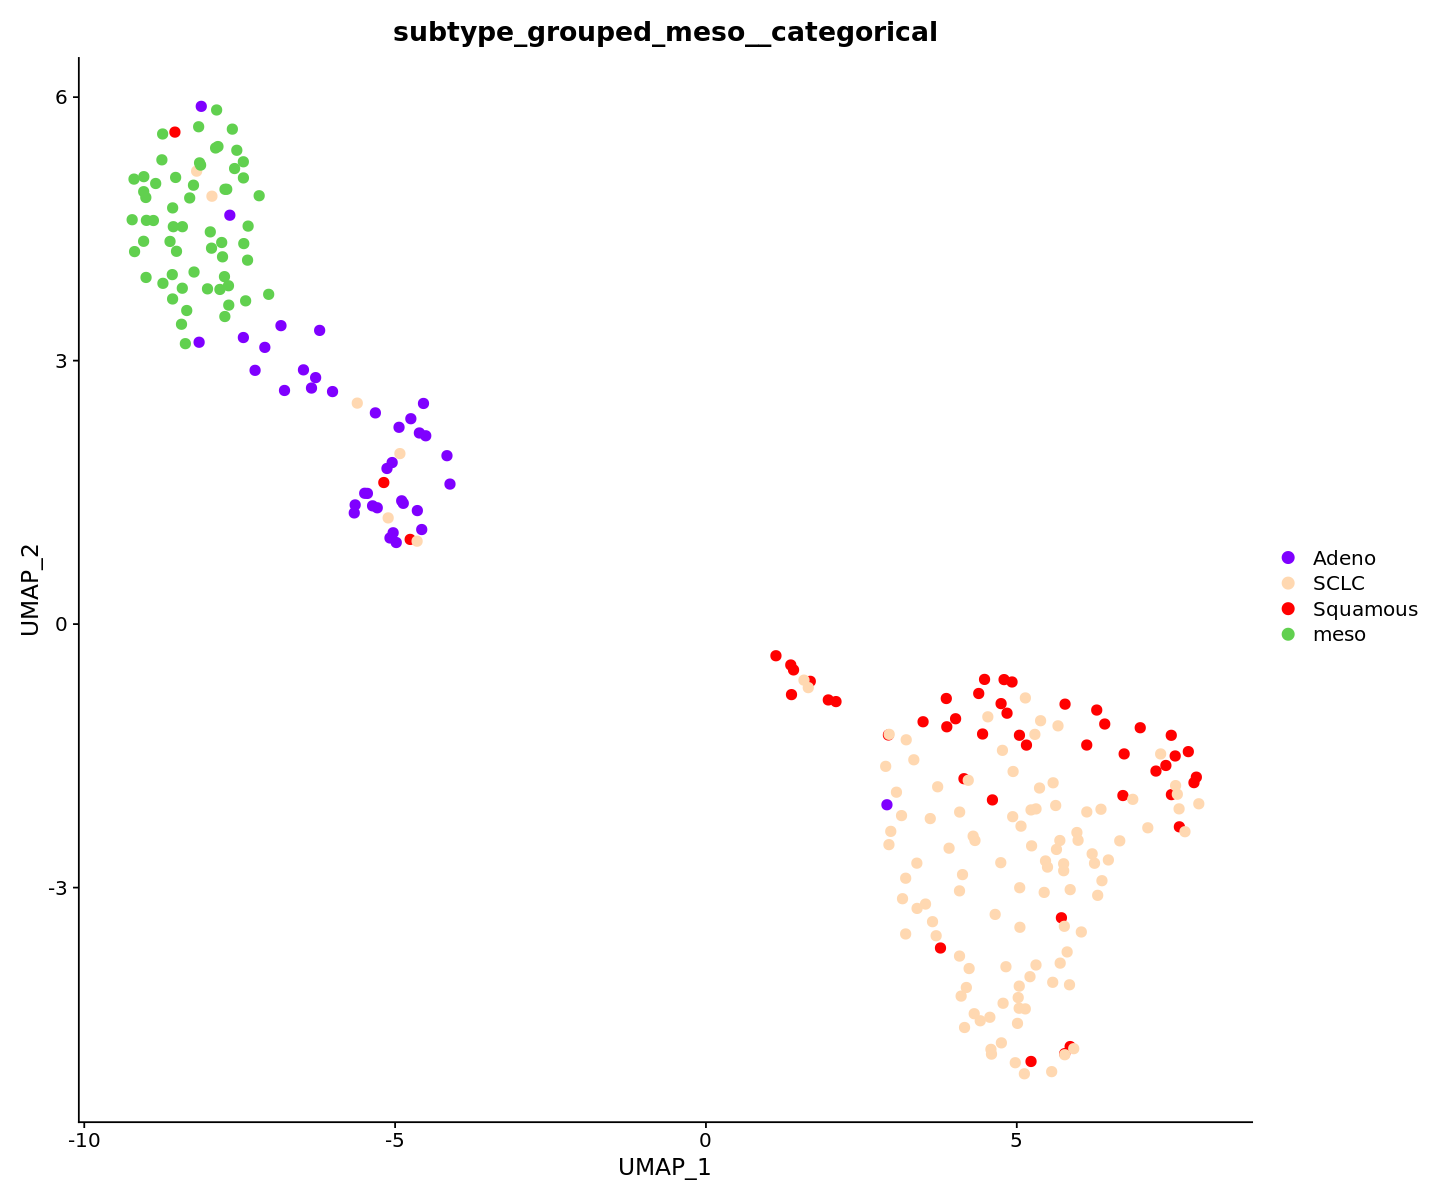

In [11]:
df = load_data("all_lung.csv")
df["subtype_grouped_meso"] = df["subtype"]
df[df["subtype"] == "Not.Otherwise.Specified" | df["subtype"] == "Epithelioid" | df["subtype"] == "Sarcomatoid"
   | df["subtype"] == "Biphasic", "subtype_grouped_meso"] = "meso"
colnames(df)[1] = "donor_id"
colnames(df)[match("subtype", colnames(df))] = "subtype__categorical"
colnames(df)[match("subtype_grouped_meso", colnames(df))] = "subtype_grouped_meso__categorical"

perform_analysis(df, 
                 scale=T,
                 normalize=T,
                 dim_reduction_method="umap",
                 plot_title="all lung",
                 color_by="subtype_grouped_meso__categorical",
                 seurat_clustering=F,
                 conduct_test=F,
                 min_mutations_per_sample=0,
                 save_clustered_mutations=F,
                 regress_out_counts = F,
                 seurat_func_args=
                   list(normalize_data_args=list(normalization.method=
                                                   "LogNormalize"),
                        find_var_features_args=list(nfeatures=2128),
                        scale_data_args=list(verbose=F),
                        pca_args=list(npcs=30, approx_svd=F, verbose=F),
                        umap_args=list(n.neighbors=30, dims=1:15, verbose=F, min.dist=0.3),
                        tsne_args=list(dims=2:15),
                        find_neighbors_args=list(dims=1:20),
                        find_clusters_args=list(resolution=0.7)),
                manually_supplied_cols = c("#7F00FF", "#FFD8B1", "#FF0000", "3EB54C"))